# Data simulation

Using the Dynamic Generalised Models library https://github.com/ruivieira/python-ssm

In [1]:
from pssm.dglm import NormalDLM
from pssm.structure import UnivariateStructure
import numpy as np

np.random.seed(23)

Each entry in the dataset will correspond to a single day.

Create a (univariate) DGLM with a period of 7 days (weekly) using a simple seasonal component with one harmonic.

This corresponds to simulating daily hits on a web server with a weekly pattern.

We will keep the underlying mean with a small variance to make it a (relatively) stable time-series.

In [2]:
weekly_period = 7

structure = UnivariateStructure.locally_constant(1.4) + \
            UnivariateStructure.cyclic_fourier(period=weekly_period, harmonics=1, W=np.identity(2)*2)

In [3]:
ndlm = NormalDLM(structure=structure, V=2.5)

In [4]:
structure.G

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.6234898 ,  0.78183148],
       [ 0.        , -0.78183148,  0.6234898 ]])

Simulate a dataset with 730 days (~2 years).

Mean server hits prior of `200`.

In [5]:
m0 = np.array([200, 0, 0])
C0 = np.identity(3)
state0 = np.random.multivariate_normal(m0, C0)

states = [state0]

N = 365

for t in range(1, N):
    states.append(ndlm.state(states[t-1]))
    
obs = [None]
for t in range(1, N):
    obs.append(ndlm.observation(states[t]))

Data for the whole series:

Text(0, 0.5, 'Hits')

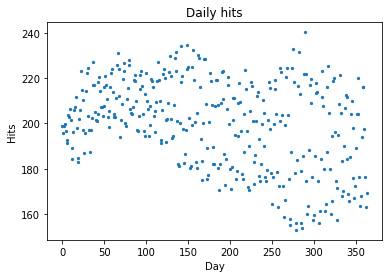

In [6]:
import matplotlib.pyplot as plt

plt.scatter(range(N-1), obs[1:], s=5)
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")

Data for the first two "months" (~60 days).

Text(0, 0.5, 'Hits')

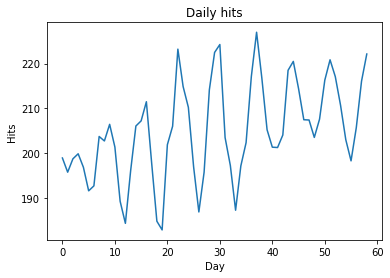

In [7]:
plt.plot(obs[1:60])
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")

Add random anomalies by increasing the state randomly.

We set the anomaly times manually just for testing, randomise later.

In [8]:
def generate_anomalous_data(structure, 
                            n_obs,
                            m0,
                            C0,
                            V,
                            anomaly_times,
                            ratio):
    ndlm = NormalDLM(structure=structure, V=V)
    state0 = np.random.multivariate_normal(m0, C0)

    states = [state0]

    for t in range(1, n_obs):
        states.append(ndlm.state(states[t-1]))
    
    for t in anomaly_times:
        states[t] = states[t] * ratio
    
    obs = [None]
    for t in range(1, N):
        obs.append(ndlm.observation(states[t]))

    return obs

Generate a new dataset with anomalies at day `27`, `53`, `270` (just for testing).

In [9]:
obs = generate_anomalous_data(structure, N, m0, C0, 2.5, [27, 53, 270], 3.0)

We will need to use observations as arrays often, so do it now.

In [10]:
Y = np.array(obs[1:]).reshape(-1,1)

Convert to integer observations

In [11]:
# Y = Y.astype(int)
Y[:10]

array([[205.30187183],
       [198.57503686],
       [199.32743799],
       [202.51439803],
       [203.5311284 ],
       [211.49508197],
       [200.99750927],
       [201.732728  ],
       [199.91033671],
       [202.54364734]])

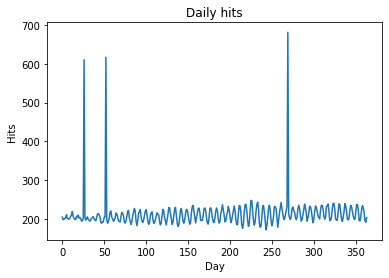

In [12]:
plt.plot(Y)
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.show()

Data for the first 60 days:

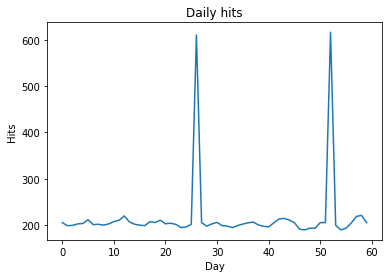

In [13]:
plt.plot(Y[:60])
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.show()

Convert into dataframe (just for plotting, really...)

In [14]:
import pandas as pd

In [15]:
df = pd.DataFrame(Y, columns=["y"])
df.head()

,y
0,205.301872
1,198.575037
2,199.327438
3,202.514398
4,203.531128


# Outlier detection

## (Local) outlier factor

Train the local outlier detector with the whole dataset[^1].

[^1]: Again, just for training purposes.

In [16]:
from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(contamination='auto', novelty=True)
clf.fit(Y)

LocalOutlierFactor(novelty=True)

Store the detected anomalies (if any) on the dataframe.

In [17]:
anomalies = clf.predict(Y)

In [18]:
df['anomaly'] = anomalies

Plot the data for the first 60 days, along with the anomalies (red).

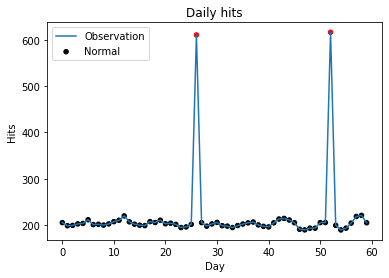

In [19]:
d = df.head(60)
plt.plot(Y[:60])
plt.scatter(x=range(60), y=d['y'], c=list(d['anomaly'].map({1: 'black', -1: 'red'})), s=20)
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.legend(['Observation', 'Normal'])

## n-$\sigma$

Using 3-$\sigma$. Calculate standard deviation:

In [20]:
bounds = [Y.mean() + 3*Y.std(), Y.mean() - 3*Y.std()]
bounds

[338.0254539410212, 88.0745223391051]

Find outliers according to our criteria.

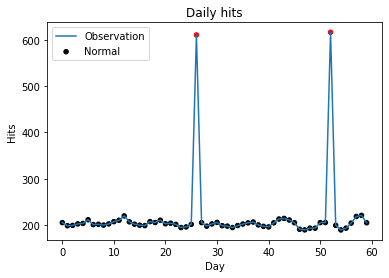

In [21]:
colours = d['y'].transform(lambda x: 'black' if x > bounds[1] and x < bounds[0] else 'red')
plt.plot(Y[:60])
plt.scatter(x=range(60), y=d['y'], c=list(colours), s=20)
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.legend(['Observation', 'Normal'])

# LSTM forecast

Forecast the data using LSTM.

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Offset the data (history size `1`, i.e. one step behind).

Normalise data for LSTM.

In [24]:
df['day'] = list(range(364))
df['day_scaled'] = df['day'] / 364.0
df.head()

,y,anomaly,day,day_scaled
0,205.301872,1,0,0.000000
1,198.575037,1,1,0.002747
2,199.327438,1,2,0.005495
3,202.514398,1,3,0.008242
4,203.531128,1,4,0.010989


In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(Y)
df['y_scaled'] = scaler.fit_transform(df['y'].to_numpy().reshape(-1, 1))
df

,y,anomaly,day,day_scaled,y_scaled
0,205.301872,1,0,0.000000,0.064829
1,198.575037,1,1,0.002747,0.051604
2,199.327438,1,2,0.005495,0.053083
3,202.514398,1,3,0.008242,0.059349
4,203.531128,1,4,0.010989,0.061347
...,...,...,...,...,...
359,229.425956,1,359,0.986264,0.112255
360,216.357362,1,360,0.989011,0.086563
361,195.701712,1,361,0.991758,0.045955
362,192.236203,1,362,0.994505,0.039142


Split into train and test datasets.

In [26]:
train_size = 200

df_train = df.loc[:train_size,:]
df_test = df.loc[train_size:,:]

In [27]:
df_train.head()

,y,anomaly,day,day_scaled,y_scaled
0,205.301872,1,0,0.000000,0.064829
1,198.575037,1,1,0.002747,0.051604
2,199.327438,1,2,0.005495,0.053083
3,202.514398,1,3,0.008242,0.059349
4,203.531128,1,4,0.010989,0.061347


In [28]:
df_test.head()

,y,anomaly,day,day_scaled,y_scaled
200,208.725080,1,200,0.549451,0.071558
201,191.208991,1,201,0.552198,0.037123
202,196.282804,1,202,0.554945,0.047097
203,209.064659,1,203,0.557692,0.072226
204,220.828433,1,204,0.560440,0.095353


In [29]:
X_train = np.reshape(df_train['day_scaled'].to_numpy(), (len(df_train['day_scaled']), 1, 1))
y_train = df_train['y_scaled'].to_numpy()

X_test = np.reshape(df_test['day_scaled'].to_numpy(), (len(df_test['day_scaled']), 1, 1))
y_test = df_test['y_scaled'].to_numpy()

Fit the LSTM.

In [31]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(50, activation='relu'))
# model.add(LSTM(4, input_shape=(1, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=125, batch_size=2, verbose=0)

Add predictions for plotting.

In [32]:
LSTM_pred = {}
LSTM_pred["train"] = model.predict(X_train)
LSTM_pred["test"] = model.predict(X_test)

Un-normalise.

In [33]:
LSTM_pred["train"] = scaler.inverse_transform(LSTM_pred["train"])
y_train = scaler.inverse_transform([y_train])
LSTM_pred["test"] = scaler.inverse_transform(LSTM_pred["test"])
y_test = scaler.inverse_transform([y_test])

Plot the time between 400th and 600th days.

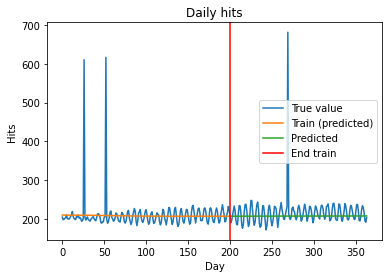

In [34]:
plt.plot(df.y)
plt.plot(LSTM_pred["train"])
plt.plot(range(200, N-1), LSTM_pred["test"])
plt.axvline(x=200, c="red")
plt.title("Daily hits")
plt.xlabel("Day")
plt.ylabel("Hits")
plt.legend(['True value', 'Train (predicted)', "Predicted", "End train"])
plt.show()

Timepoint `t=268` (non-anomalous in our data)

In [35]:
t=268
Y[t]

array([232.46136799])

Should be non-anomalous (`p=1`)

In [36]:
clf.predict(np.array(Y[t]).reshape(-1, 1))

array([1])

Predicted observation:

In [37]:
prediction = model.predict(scaler.transform(np.array([t-1]).reshape(-1, 1)))
print(f"Observed value = {round(Y[t][0])} hits, predicted = {round(scaler.inverse_transform(prediction)[0][0])} hits")

Observed value = 232 hits, predicted = 209 hits


Now, timepoint `t=269` (**anomalous** in our data)

In [38]:
t=269
Y[t]

array([680.98464193])

Should be **anomalous** (`p=-1`)

In [39]:
clf.predict(np.array(Y[t]).reshape(-1, 1))

array([-1])

Predicted observation:

In [40]:
prediction = model.predict(scaler.transform(np.array([t-1]).reshape(-1, 1)))
print(f"Observed value = {round(Y[t][0])} hits, predicted = {round(scaler.inverse_transform(prediction)[0][0])} hits")

Observed value = 681 hits, predicted = 209 hits
